##### Copyright 2023 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Training a Text Classifier Using Embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/examples/train_text_classifier_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/examples/train_text_classifier_embeddings.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

In this notebook, you'll learn to use the embeddings produced by the PaLM API to train a model that can classify different types of newsgroup posts based on the topic.

In this tutorial, you'll train a classifier to predict which class a newsgroup post belongs to.

## Setup

First, download and install the PaLM API Python library.

In [ ]:
!pip install -q google-generativeai

In [ ]:
import google.generativeai as palm

import re
import tqdm
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt


from keras import layers
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups

### Get an API Key

To get started, you'll need to [create an API key](https://developers.generativeai.google/tutorials/setup).

In [ ]:
palm.configure(api_key='PALM_KEY')

Key Point: Next, you will choose a model. Any embedding model will work for this tutorial, but for real applications it's important to choose a specific model and stick with it. The outputs of different models are not compatible with each other.

In [ ]:
models = [m for m in palm.list_models() if 'embedText' in m.supported_generation_methods]

model = models[0]

## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will be using the subsets of the training and test datasets. You will preprocess and organize the data into Pandas dataframes.

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is an example of what a data point from the training set looks like.

In [ ]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Now you will begin preprocessing the data for this tutorial. Remove any sensitive information like names, email, or redundant parts of the text like `"From: "` and `"\nSubject: "`. Organize the information into a Pandas dataframe so it is more readable.

In [ ]:
def preprocess_newsgroup_data(newsgroup_dataset):
  # Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
  newsgroup_dataset.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroup_dataset.data] # Remove email
  newsgroup_dataset.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroup_dataset.data] # Remove names
  newsgroup_dataset.data = [d.replace("From: ", "") for d in newsgroup_dataset.data] # Remove "From: "
  newsgroup_dataset.data = [d.replace("\nSubject: ", "") for d in newsgroup_dataset.data] # Remove "\nSubject: "

  # Put data points into dataframe
  df_processed = pd.DataFrame(newsgroup_dataset.data, columns=['Text'])
  df_processed['Label'] = newsgroup_dataset.target
  # Match label to target name index
  df_processed['Class Name'] = ''
  for idx, row in df_processed.iterrows():
    df_processed.at[idx, 'Class Name'] = newsgroup_dataset.target_names[row['Label']]

  return df_processed

In [ ]:
# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [ ]:
def sample_data(df, num_samples, classes_to_keep):
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)

  df = df[df['Class Name'].str.contains(classes_to_keep)]

  # Reset the encoding of the labels after sampling and dropping certain categories
  df['Class Name'] = df['Class Name'].astype('category')
  df['Encoded Label'] = df['Class Name'].cat.codes

  return df

In [ ]:
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = 'sci' # Class name should contain 'sci' in it to keep science categories
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [ ]:
df_train.value_counts('Class Name')

Class Name
sci.crypt          100
sci.electronics    100
sci.med            100
sci.space          100
dtype: int64

In [ ]:
df_test.value_counts('Class Name')

Class Name
sci.crypt          25
sci.electronics    25
sci.med            25
sci.space          25
dtype: int64

## Create the embeddings

Next, you need to compute the text embeddings. You will be using the PaLM API to [generate embeddings](https://developers.generativeai.google/api/python/google/generativeai/generate_embeddings). For a basic understanding of how the generation of embeddings works, it's recommended to go through the [embeddings quickstart notebook](../tutorials/embeddings_quickstart.ipynb) first.

**NOTE**: Embeddings are computed one at a time, large sample sizes can take a long time!

In [ ]:
from google.api_core import retry

# Define a function with automatic retry logic to compute embeddings and wait
# a bit once the quota limit has been reached.
@retry.Retry(timeout=30.0)
def embed_text(model, text: str) -> list[float]:
  x = palm.generate_embeddings(model=model, text=text)
  return np.array(x['embedding'])

def create_embeddings(model, df):
  # Create embeddings for each document and add that as a column to the dataframe
  df['Embeddings'] = ''
  for idx, row in tqdm.tqdm(df.iterrows(), total=df.shape[0]):
    df.at[idx, 'Embeddings'] = embed_text(model, row['Text'])
  return df

In [ ]:
df_train = create_embeddings(model, df_train)
df_test = create_embeddings(model, df_test)

100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


In [ ]:
df_train.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,"Re: Once tapped, your code is no good any mor...",11,sci.crypt,0,"[-0.0068779737, -0.01800009, -0.008543506, 0.0..."
1101,Re: Clipper Crap\nOrganization: University of...,11,sci.crypt,0,"[-0.0069657, -0.015098701, 0.018802924, 0.0603..."
1102,Re: The source of that announcement\nOrganiza...,11,sci.crypt,0,"[0.010320705, -0.029472735, 0.015192655, 0.047..."
1103,"Re: I have seen the lobby, and it is us\nOrga...",11,sci.crypt,0,"[-0.0017293844, -0.026546137, 0.030813301, 0.0..."
1104,Re: Is there ANY security in the Clipper?\nOrg...,11,sci.crypt,0,"[-0.004387771, -0.011773602, 0.019989792, 0.03..."


## Build a simple classification model
Here you will define a simple model with one hidden layer and a single class probability output. The prediction will correspond to the probability of a piece of text being a particular class of news. When you build your model, Keras will automatically shuffle the data points.

In [ ]:
def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
  inputs = x = keras.Input(input_size, dtype=tf.float32)
  x = layers.Dense(input_size, activation='relu')(x)
  x = layers.Dense(num_classes, activation='sigmoid')(x)
  return keras.Model(inputs=[inputs], outputs=x)

In [ ]:
# Derive the embedding size from the first training element.
embedding_size = len(df_train['Embeddings'].iloc[0])

# Give your model a different name, as you have already used the variable name 'model'
classifier = build_classification_model(embedding_size, len(df_train['Class Name'].unique()))
classifier.summary()

classifier.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   optimizer = keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 768)               590592    
                                                                 
 dense_1 (Dense)             (None, 4)                 3076      
                                                                 
Total params: 593,668
Trainable params: 593,668
Non-trainable params: 0
_________________________________________________________________


In [ ]:
embedding_size

768

## Train the model to classify newsgroups

Finally, you can train a simple model. Use a small number of epochs to avoid overfitting. The first epoch takes much longer than the rest, because the embeddings need to be computed only once.

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = df_train['Encoded Label']
x_train = np.stack(df_train['Embeddings'])
y_val = df_test['Encoded Label']
x_val = np.stack(df_test['Embeddings'])

# Train the model for the desired number of epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = classifier.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         callbacks=[callback],
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 1s 33ms/step - loss: 1.2384 - accuracy: 0.6850 - val_loss: 1.0481 - val_accuracy: 0.8900
Epoch 2/20
13/13 [==============================] - 0s 9ms/step - loss: 0.8483 - accuracy: 0.9075 - val_loss: 0.7267 - val_accuracy: 0.9100
Epoch 3/20
13/13 [==============================] - 0s 10ms/step - loss: 0.5258 - accuracy: 0.9325 - val_loss: 0.4687 - val_accuracy: 0.9700
Epoch 4/20
13/13 [==============================] - 0s 11ms/step - loss: 0.3288 - accuracy: 0.9600 - val_loss: 0.3400 - val_accuracy: 0.9600
Epoch 5/20
13/13 [==============================] - 0s 11ms/step - loss: 0.2381 - accuracy: 0.9575 - val_loss: 0.2740 - val_accuracy: 0.9700
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.1827 - accuracy: 0.9675 - val_loss: 0.2277 - val_accuracy: 0.9600
Epoch 7/20
13/13 [==============================] - 0s 10ms/step - loss: 0.1563 - accuracy: 0.9750 - val_loss: 0.2295 - val_accuracy: 0.9400
Epoch 8/20
13/13 [=======

## Evaluate model performance

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset.

In [ ]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 [==============================] - 0s 5ms/step - loss: 0.1537 - accuracy: 0.9300


{'loss': 0.15373578667640686, 'accuracy': 0.9300000071525574}

One way to evaluate your model performance is to visualize the classifier performance. Use `plot_history` to see the loss and accuracy trends over the epochs.

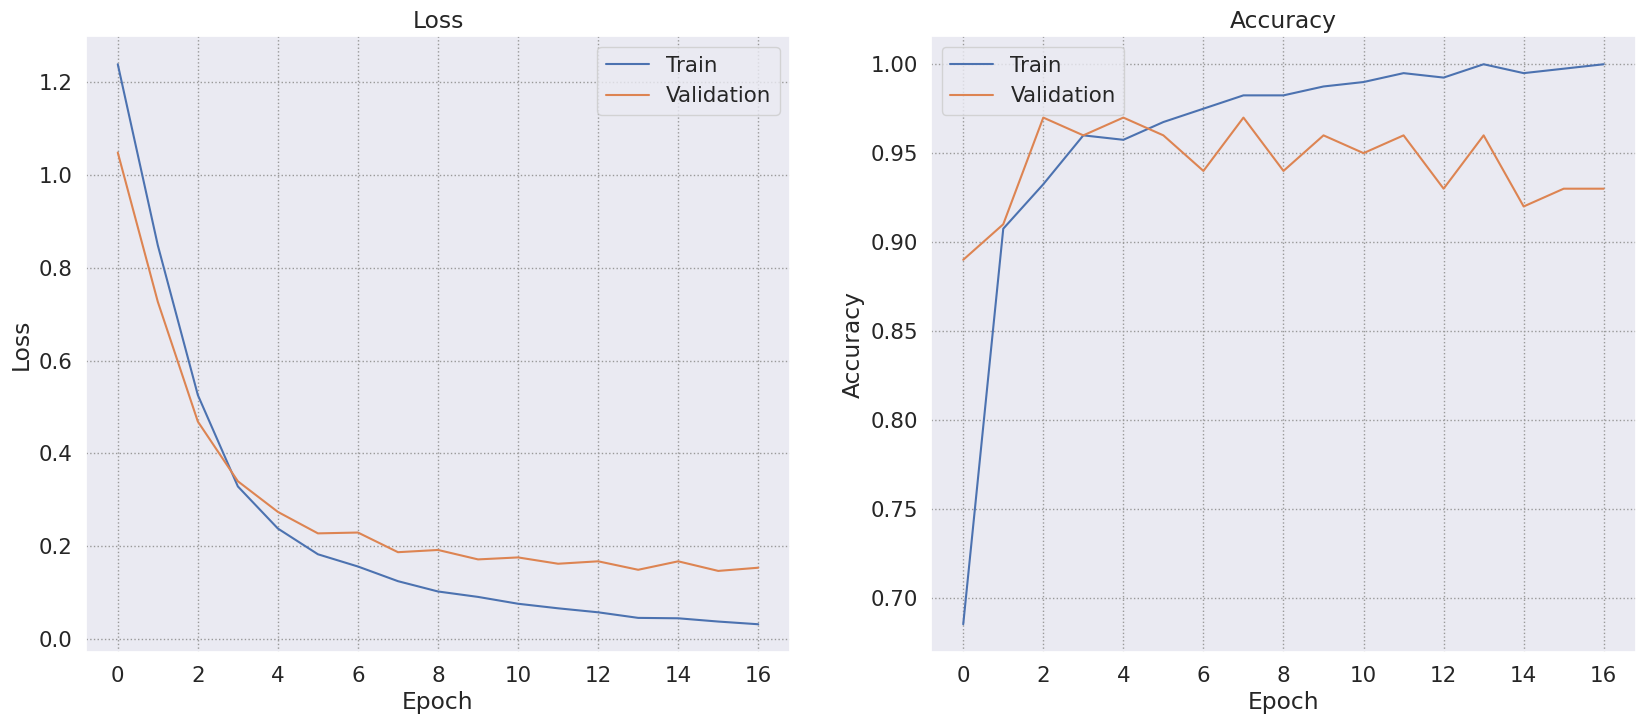

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

Another way to view model performance, beyond just measuring loss and accuracy is to use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. You can see what misclassified points get classified as. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

Start by generating the predicted class for each example in the validation set using `Model.predict()`.

In [ ]:
y_hat = classifier.predict(x=x_val)
y_hat = np.argmax(y_hat, axis=1)

4/4 [==============================] - 0s 4ms/step


In [ ]:
labels_dict = dict(zip(df_test['Class Name'], df_test['Encoded Label']))
labels_dict

{'sci.crypt': 0, 'sci.electronics': 1, 'sci.med': 2, 'sci.space': 3}

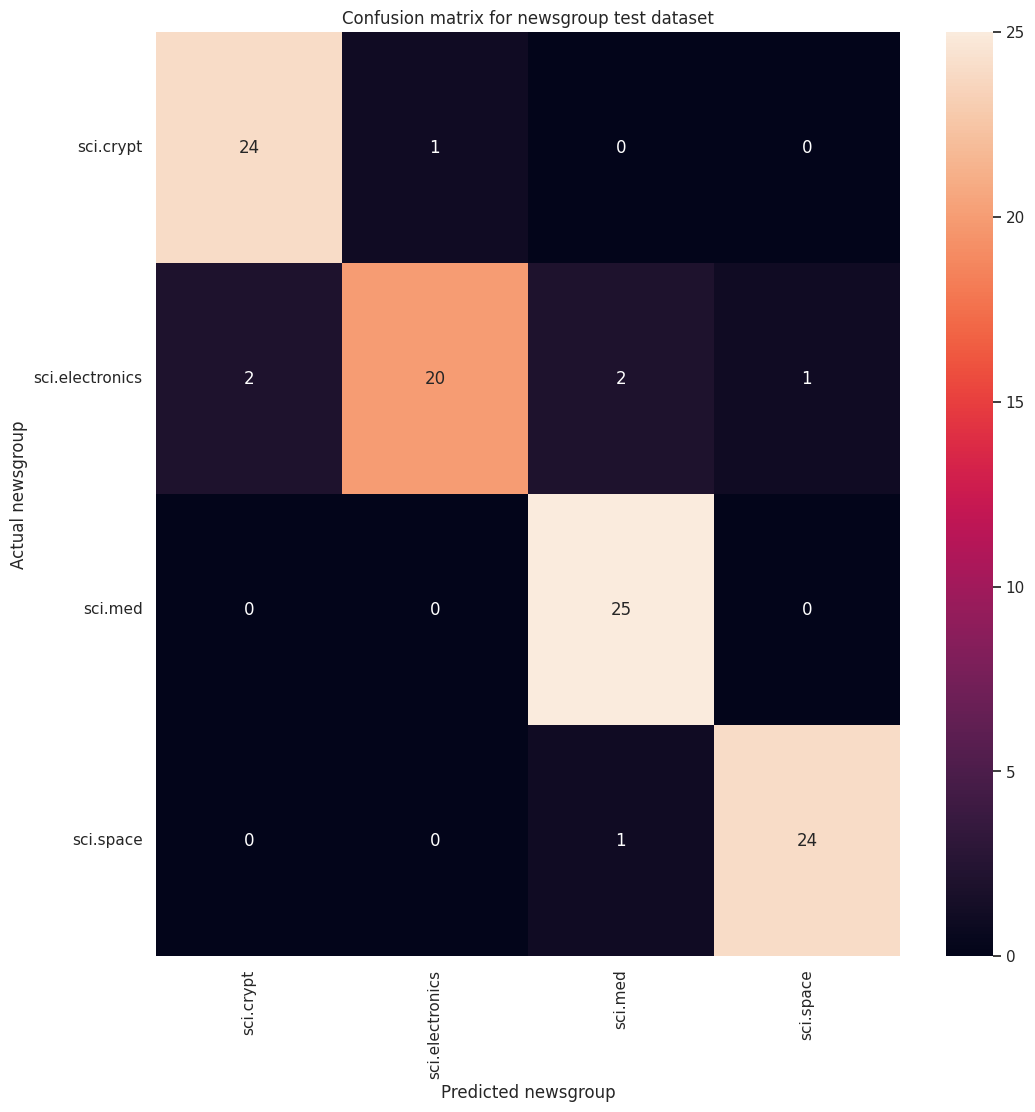

In [ ]:
cm = tf.math.confusion_matrix(y_val, y_hat)
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion matrix for newsgroup test dataset')
ax.set_xlabel('Predicted newsgroup')
ax.set_ylabel('Actual newsgroup')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

ax.xaxis.set_ticklabels(labels_dict)
ax.yaxis.set_ticklabels(labels_dict)
plt.show()

## Next steps

You've now created your own text classifier using embeddings generated from the PaLM API! Try using your own textual data to train a model. One possible dataset could be the [Jigsaw Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data){:.external} to create your own toxicity classifier.

To learn more about how you can use the embeddings, check out the examples available. To learn how to use other services in the PaLM API, visit the various quickstart guides:

* [Chat quickstart](../tutorials/chat_quickstart.ipynb)

* [Text generation quickstart](../tutorials/text_quickstart.ipynb)